# Making mid-experiment temp validation plots

In [1]:
import pandas as pd
from os.path import join,isdir
from os import listdir
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from datetime import time,timedelta,datetime as dt
from glob import glob
import pdb

# Figure settings
sns.set()
sns.set_context('talk')
%matplotlib inline

# Path settings
home_dir = '/Users/ianbolliger/Dropbox/Temperature & Behavior/Experiments'

# Utility Funcs

In [175]:
def load_co2_vals(download_dates,base_dir):
    co2_dfs = {'treatment':pd.DataFrame(),
               'control':pd.DataFrame()}
    base_path = join(base_dir,'Other Environmental Vars')
    for i in download_dates:
        d_str = i.strftime('%Y%m%d')
        if isdir(join(base_path,d_str)):
            for t in ['treatment','control']:
                f = join(base_path,d_str,'{}_co2.csv'.format(t))
                df = pd.read_csv(f,usecols=[1,4],index_col=0,parse_dates=True,header=1)
                df.index.name = 'time'
                df.columns = ['CO2']
                
                # drop button press and other non-measurements
                df = df[df['CO2'].notnull()]
                
                # append to growing dataframe
                co2_dfs[t] = co2_dfs[t].append(df)
    
    for t in ['treatment','control']:
        co2_dfs[t] = co2_dfs[t][~co2_dfs[t].index.duplicated(keep='last')].sort_index()
                
    return co2_dfs
    

def load_t_op_vals(download_dates,base_dir):
    top_fpaths = {'treatment':[],
                 'control':[]}
    for i in download_dates:
        base_path = join(base_dir,i.strftime('%Y%m%d'),'csvs')
        for t in ['treatment','control']:
            top_fpaths[t] = top_fpaths[t] + glob(join(base_path,'{}_ot.csv'.format(t)))

    top_dfs = {'treatment':pd.DataFrame(),
              'control':pd.DataFrame()}
    for t in ['treatment','control']:
        for f in top_fpaths[t]:
            df = pd.read_csv(f,usecols=[1,4],index_col=0,parse_dates=True,header=1)
            df.index.name = 'time'
            df.columns = ['T_o']
            top_dfs[t] = top_dfs[t].append(df)

        top_dfs[t] = top_dfs[t][~top_dfs[t].index.duplicated(keep='last')].sort_index()
    
    return top_dfs

def correct_raw_timing_df(timing_df,start_date,end_date):
    idx = pd.IndexSlice
    timing_df = timing_df.loc[idx[start_date:end_date,:],:]

    # Drop cancelled sessions
    timing_df = timing_df[~((timing_df['Time entering room'].isin(["Cancelled",'canceled',''])) | (timing_df['Time entering room'].isnull()))]

    # Convert to datetime objects
    timing_df['start_time'] = pd.to_datetime(
        timing_df.index.get_level_values(0).astype(str) + 'T' + timing_df['Time entering room'])
    timing_df['end_time'] = pd.to_datetime(
        timing_df.index.get_level_values(0).astype(str) + 'T' + timing_df['Time ending modules'])

    # Impute end time from other concurrent session if not recorded
    min_end_times = timing_df.groupby(level=[0,1])['end_time'].min()
    max_start_times = timing_df.groupby(level=[0,1])['start_time'].max()
    imputed_vals = pd.DataFrame({'min_end_time':min_end_times,
                   'max_start_time':max_start_times},index = min_end_times.index)

    imputed_vals = imputed_vals.append(imputed_vals)
    imputed_vals['Treatment group'] = [0] * int(imputed_vals.shape[0] / 2) + [1] * int(imputed_vals.shape[0] / 2)
    imputed_vals = imputed_vals.set_index('Treatment group',append=True)

    timing_df = timing_df.join(imputed_vals)
    timing_df.loc[:,'start_time'] = timing_df.loc[:,'start_time'].where(
        cond=timing_df.loc[:,'start_time'].notnull(), other=timing_df['max_start_time'])
    timing_df.loc[:,'end_time'] = timing_df.loc[:,'end_time'].where(
        cond=timing_df.loc[:,'end_time'].notnull(), other=timing_df['min_end_time'])

    timing_df = timing_df[['start_time','end_time']]

    ## Correct for not using 24 hour clock
    for i in ['start_time','end_time']:
        bad_times_bool = (timing_df[i].dt.time < time(8))
        bad_times = timing_df.loc[bad_times_bool,i]
        new_times = bad_times + timedelta(hours=12)
        timing_df[i] = timing_df[i].where(bad_times_bool==False,other=new_times)
        
    # correct potential string values for session number
    timing_df.index = timing_df.index.remove_unused_levels()
    timing_df.index = timing_df.index.set_levels(timing_df.index.levels[1].astype(int),level=1)
    
    return timing_df


def make_full_plots(dfs,timing_df,out_name,site_str='Berkeley',dfs_od=None, interval_top=5,
                   interval_co2=5, plot_top=True, plot_co2=True):
    
    if site_str == 'Berkeley':
        positions = ('partition','RA')
        positions_pretty = ('Behind Partition','Under RA Desk')
    elif site_str == 'Busara':
        positions = ('near','far')
        positions_pretty = ('Near','Far')
        
    experiment_dates = timing_df.index.get_level_values(0).unique()
    n_ex = len(experiment_dates)

    pretty_metrics = ['Temperature', 'RH', 'CO2']
    marker_colors = ['b','g','r','c']
    
    for mi,metric in enumerate(['T','RH','CO2']):
        
        # skip if we don't have CO2 yet
        if metric == 'CO2' and ('co2' not in dfs.keys()):
            continue
            
        # share axes for all non-T metrics
        if metric == 'T': share = False
        else: share = True
            
        fig,ax = plt.subplots(n_ex,2,figsize = (12,n_ex*6),sharey=share)
        
        if len(experiment_dates) == 1: ax = np.array([ax])
        first_ax = ax[0,0]
        second_ax = ax[0,1]
        last_ax = ax[n_ex-1,1]
        
        for ei,e in enumerate(experiment_dates):
            if e < pd.to_datetime(sensor_swap_date):
                interval = sensor_interval_early
            else:
                interval = sensor_interval
                
                
            # load min, mean, max outside temps for that day
            if dfs_od:
                od_data = {'min':dfs_od['min'][e.date()],
                          'mean':dfs_od['mean'][e.date()],
                          'max':dfs_od['max'][e.date()]}
            
            for gi,g in enumerate(['control','treatment']):
                
                this_ax = ax[ei,gi]
                
                # loop over sessions in a day
                n_sesh = list(timing_df.index.levels[1])
                for sesh in n_sesh:
                    
                    # skip if session was cancelled
                    this_group = (e,sesh,gi)
                    if this_group not in timing_df.index:
                        continue
                    times = timing_df.loc[this_group]
                    
                    # produce values for behind partition and under RA desk
                    if metric != 'CO2':
                        metric_df = dfs[g][positions[0]].loc[times['start_time']:times['end_time'],metric]
                        metric_df = metric_df.reset_index(drop=True)
                        metric_df.index = metric_df.index*interval
                        metric_df.name = '{} {}, Session {}'.format(pretty_metrics[mi],positions_pretty[0],sesh)
                        metric_df.plot(ax=this_ax,color=marker_colors[int(sesh)-1])

                        metric_df = dfs[g][positions[1]].loc[times['start_time']:times['end_time'],metric]
                        metric_df = metric_df.reset_index(drop=True)
                        metric_df.index = metric_df.index*interval
                        metric_df.name = '{} {}, Session {}'.format(pretty_metrics[mi],positions_pretty[1],sesh)
                        metric_df.plot(ax=this_ax,style=':',color=marker_colors[int(sesh)-1])

                        # produce values for operating temp
                        if metric == 'T' and plot_top:
                            metric_df = dfs['t_op'][g].loc[times['start_time']:times['end_time'],'T_o']
                            if metric_df.shape[0] > 0:
                                metric_df = metric_df.reset_index(drop=True)
                                metric_df.index = metric_df.index*interval_top
                                metric_df.name = 'T_op, Session {}'.format(sesh)
                                metric_df.plot(ax=this_ax,style='--',color=marker_colors[int(sesh)-1])
                            
                    # produce co2 values
                    else:
                        metric_df = dfs['co2'][g].loc[times['start_time']:times['end_time'],'CO2']
                        if metric_df.shape[0] > 0:
                            metric_df = metric_df.reset_index(drop=True)
                            metric_df.index = metric_df.index*interval_co2
                            metric_df.name = 'CO2, Session {}'.format(sesh)
                            metric_df.plot(ax=this_ax,style='-.',color=marker_colors[int(sesh)-1])
                        
                    if dfs_od:
                        xlim = this_ax.get_xlim()
                        for i in [('r','min'),('b','mean'),('r','max')]:
                            this_ax.plot(xlim,[od_data[i[1]]],i[0])
                        
                this_ax.set_title('{}, {}'.format(e.date(), g.title()))
        
        last_ax.legend(loc='lower right')
        last_ax.set_xlabel('Minutes')
        ax[-1,0].set_xlabel('Minutes')
        
        # share axes down columns
        if metric != 'CO2':
            for ax_tmp in [ax]:
                for i in [0,1]:
                    axes_ylims = [ax_tmp[j,i].get_ylim() for j in range(n_ex)]
                    min_y = min([j[0] for j in axes_ylims])
                    max_y = max([j[1] for j in axes_ylims])
                    [ax_tmp[j,i].set_ylim((min_y,max_y)) for j in range(n_ex)]
                ax_tmp[0,0].get_shared_y_axes().join(*list(ax[:,0]))
                ax_tmp[0,1].get_shared_y_axes().join(*list(ax[:,1]))
        
        fig.suptitle('{} {} Measurements'.format(
            site_str.title(),pretty_metrics[mi]),fontsize=18)
        fig.tight_layout()
        fig.subplots_adjust(top=.95)
        fig.savefig('../../results/figures/main_experiment/{}_{}_{}.png'.format(out_name,site_str,metric))

    return None

def plot_means(means,means_this_week,od_data,loc_names,out_name,site_str='Berkeley',
               tx_RA_only=False):
    for m in ['T','RH','CO2']:
        
        # if not temperature, we want same axes for control/tx
        if m == 'T': share=False
        else: share = True
            
        fig,ax = plt.subplots(1,2,figsize = (18,6), sharey=share)
        mean_of_means = {}
        std_of_means = {}
        for ix,i in enumerate(['control','treatment']):
            mean_temps = pd.DataFrame(means[i][m])
            mean_temps.plot(ax=ax[ix])
            ax[ix].set_title('Mean {} per experiment, {}'.format(m,i.title()))
            ax[ix].legend(loc='upper right')
            lns1 = ax[ix].get_lines()

            if m == 'T':
                ax2 = ax[ix].twinx()
                ax2.grid(False,which='both')
                od_mean_temps = pd.Series(od_data['T']['mean'],name='Mean Daily T')
                with sns.axes_style('dark'):
                    od_mean_temps.plot(ax=ax2,color='r')
                lns2 = ax2.get_lines()

                lns = lns1 + lns2
                ax[ix].set_ylabel('Room Temps, C')
                ax2.set_ylabel('Mean Daily Outdoor T, C')
            else:
                lns = lns1
                ax[ix].set_ylabel('{}'.format(m))
            ax[ix].set_xlabel('Experiment #') 
            labs = [l.get_label() for l in lns]
            ax[ix].legend(lns, labs, loc='upper left')

            
            mean_of_means[i]={}
            tmp_means_overall = means[i][m]
            tmp_means_this_wk = means_this_week[i][m]
            if m in ['T','RH']:
                tmp_means_overall_sensor_avg = (np.array(
                    tmp_means_overall[loc_names[1]]) + np.array(
                    tmp_means_overall[loc_names[0]])) / 2
            else:
                tmp_means_overall_sensor_avg = np.array(tmp_means_overall)
            std_of_means[i] = np.nanstd(tmp_means_overall_sensor_avg)

            if m == 'T':
                if tx_RA_only and i == 'treatment':
                    mean_of_means[i]['overall'] = np.nanmean(np.array(tmp_means_overall['RA']))
                    mean_of_means[i]['this_wk'] = np.nanmean(np.array(tmp_means_this_wk['RA']))
                    RA_note = "RA sensor only, "
                else:
                    mean_of_means[i]['overall'] = np.nanmean(
                        np.array(tmp_means_overall[loc_names[1]] + tmp_means_overall[loc_names[0]]))
                    mean_of_means[i]['this_wk'] = np.nanmean(np.array(
                        tmp_means_this_wk[loc_names[1]] + tmp_means_this_wk[loc_names[0]]))
                    RA_note = ""
                mean_of_means[i]['T_op'] = np.nanmean(np.array(tmp_means_overall['T_op']))

                ax[ix].text(x = .02,y=.02,s="""
Mean of means ({}overall, air): {:.2f}
Std. of means ({}overall, air): {:.2f}
Mean of means ({}last wk, air): {:.2f}
Mean of means ({}overall, operative): {:.2f}""".format(
                    RA_note, mean_of_means[i]['overall'],RA_note, std_of_means[i],RA_note, mean_of_means[i]['this_wk'],
                    RA_note, mean_of_means[i]['T_op']),fontsize=14,
                    transform = ax[ix].transAxes,horizontalalignment='left',verticalalignment='bottom')

            else:
                if m == 'RH':
                    mean_of_means[i]['overall'] = np.nanmean(
                        np.array(tmp_means_overall[loc_names[1]] + tmp_means_overall[loc_names[0]]))
                    mean_of_means[i]['this_wk'] = np.nanmean(np.array(
                        tmp_means_this_wk[loc_names[1]] + tmp_means_this_wk[loc_names[0]]))
                else:
                    mean_of_means[i]['overall'] = np.nanmean(np.array(tmp_means_overall))
                    mean_of_means[i]['this_wk'] = np.nanmean(np.array(tmp_means_this_wk))
                    
                ax[ix].text(x = .02,y=.02,s="""
Mean of means (overall): {:.2f}
Std. of means (overall): {:.2f}
Mean of means (last wk): {:.2f}""".format(
                    mean_of_means[i]['overall'], std_of_means[i], mean_of_means[i]['this_wk']),fontsize=14,
                    transform = ax[ix].transAxes,horizontalalignment='left',verticalalignment='bottom')
                
        fig.savefig('../../results/figures/main_experiment/{}_{}_{}.png'.format(out_name,site_str,m))
    
    return None

def get_session_level_data(dfs,timing_df):
    experiment_dates = timing_df.index.get_level_values(0).unique()
    n_ex = len(experiment_dates)
    loc_names = list(dfs['treatment'].keys())
    dfs_od = dfs['outdoor']

    pretty_metrics = ['Temperature','RH']
    marker_colors = ['b','g']
    
    means_id = {}
    od_data = {}
    for i in ['T','RH']:
        od_data[i] = {}
        for j in ['min','mean','max']:
            od_data[i][j] = []
            
    for gi,g in enumerate(['control','treatment']):
        
        means_id[g] = {}
        
        for m in ['T','RH']:
            means_id[g][m]={}
            for area in loc_names:
                means_id[g][m][area] = []
        means_id[g]['T']['T_op'] = []
        means_id[g]['CO2'] = []
            
        for e in experiment_dates:
            for s in [1,2]:

                # skip if session was cancelled
                this_group = (e,s,gi)
                if this_group not in timing_df.index:
                    continue
                times = timing_df.loc[this_group]

                # get means for behind partition and under RA desk
                for area in loc_names:
                    metric_df = dfs[g][area].loc[times['start_time']:times['end_time'],:]
                    this_means = metric_df.mean()
                    for m in ['T','RH']:
                        means_id[g][m][area].append(this_means[m])

                # get T_op mean
                if 't_op' in dfs.keys():
                    metric_df = dfs['t_op'][g].loc[times['start_time']:times['end_time'],:]
                    this_means = metric_df.mean()
                    if this_means.shape[0]:
                        means_id[g]['T']['T_op'].append(this_means['T_o'])
                    else:
                        means_id[g]['T']['T_op'].append(np.nan)
                else:
                    means_id[g]['T']['T_op'].append(np.nan)
                    
                # get CO2 mean
                if 'co2' in dfs.keys():
                    metric_df = dfs['co2'][g].loc[times['start_time']:times['end_time'],:]
                    this_means = metric_df.mean()
                    if this_means.shape[0]:
                        means_id[g]['CO2'].append(this_means['CO2'])
                    else:
                        means_id[g]['CO2'].append(np.nan)
                else:
                    means_id[g]['CO2'].append(np.nan)
                
                # get outdoor mean (only need to do once)
                if gi == 0:
                    for i in ['min','mean','max']:
                        for m in ['T','RH']:
                            try:
                                this_data = dfs_od[i].loc[e.date(),m]
                            except:
                                this_data = np.nan
                            od_data[m][i].append(this_data)
            
    return means_id,od_data,loc_names

def get_outdoor_data(temp_dir):
    files_od = glob(join(temp_dir,'20*.xlsx'))
    df_od = pd.DataFrame()

    for f in files_od:
        this_df = pd.read_excel(f,sheet_name='DATA',usecols='B:D',index_col=0,parse_dates=True)
        this_df.columns = ['T','RH']
        this_df.index.name = 'time'

        # convert to celsius
        this_df['T'] = (this_df['T'] - 32) * 5/9
        df_od = df_od.append(this_df)

    df_od = df_od[~df_od.index.duplicated(keep='last')].sort_index()
    
    # remove first and last day to ignore days where we did not get full recording
    df_od = df_od.iloc[1:-1,:]
    
    # separate out into daily min,mean,max
    groups = df_od.groupby(df_od.index.date)
    dfs_od = {'all':df_od,
             'min': groups.min(),
             'mean': groups.mean(),
             'max': groups.max()}
    
    for i in ['min','mean','max']:
        # remove first and last day to ignore days where we did not get full recording
        dfs_od[i] = dfs_od[i].iloc[1:-1,:]
    
    
    return dfs_od

# Berkeley

In [48]:
berk_dir = join(home_dir,'Xlab data','Main experiment data')
timing_fpath_berk = join(berk_dir,'experiment_timing.csv')

temps_dir_berk = join(berk_dir,'Temperature')

start_date = '2017-09-25'
full_fig_start_date = '2017-12-04'
end_date = '2017-12-20'

sensor_swap_date = '2017-10-03'
sensor_interval_early = 5
sensor_interval = 1

out_name = '{}_detailed'.format(end_date)
out_name_means = '{}_means'.format(end_date)
download_dates_berk = [dt.strptime(i,'%Y%m%d') for i in listdir(join(temps_dir_berk,'indoor')) if i[0] != '.']
download_dates_berk.sort()

## Get session timing data

In [4]:
# Load csv containing start and stop times for session
raw_timing_df_berk = pd.read_csv(timing_fpath_berk,index_col = [0,1,2], parse_dates = True,
            usecols=['Date','Session in day','Treatment group','Time entering room','Time ending modules'])

timing_df = correct_raw_timing_df(raw_timing_df_berk,start_date,end_date)

## Get temp/RH data from sessions, CO2 from sessions, outdoor temp/RH

In [14]:
def load_vals_berkeley(download_dates):
    """Input all temperature data from Berkeley experiment into dataframe."""
    
        download_dates = s.download_dates_berk
    sensor_swap_date = s.sensor_swap_date
    
    dfs = {'treatment':{},
          'control':{}}
    
    # co2
    dfs['co2'] = load_co2_vals(download_dates,berk_dir)
    
    # outdoor temp
    dfs['outdoor'] = get_outdoor_data(join(temps_dir_berk,'Outdoor'))
    
    # base directory for indoor temp measurements
    indoor_temp_dir = join(temps_dir_berk,'indoor')
    
    # operative temp
    dfs['t_op'] = load_t_op_vals(download_dates,indoor_temp_dir)

    print("Downloading {}...".format(download_dates[0]))
    
    # grab room temp data from both control and treatment rooms
    for gi,g in enumerate(['control','treatment']):
        
        ## download data from early in experiment when we were using different sensors
        dfs[g]['partition'] = pd.read_excel(join(indoor_temp_dir,download_dates[0].strftime('%Y%m%d'),'{}_p.xls'.format(g)),
                          sheet_name='Records',parse_dates=True,index_col=0).loc[:pd.to_datetime(sensor_swap_date),:]
        
        dfs[g]['RA'] = pd.read_excel(join(indoor_temp_dir,download_dates[0].strftime('%Y%m%d'),'{}_RA.xls'.format(g)),
                          sheet_name='Data Table',parse_dates=True,index_col=1,header=21).iloc[:,1].loc[:pd.to_datetime(sensor_swap_date)]
        dfs[g]['RA'].name = 'T'
        dfs[g]['RA'] = pd.DataFrame(dfs[g]['RA'])
        dfs[g]['RA']['RH'] = np.nan
        
        for loc in ['partition','RA']:  
            dfs[g][loc].columns = ['T','RH']
            dfs[g][loc].index.name='time'
        
        ## now download data from sensors we switched to
        for d in download_dates[1:]:
            print("Downloading {}...".format(d))
            for loc in [('partition','p'),('RA','RA')]:
                new_df = pd.read_csv(join(indoor_temp_dir,d.strftime('%Y%m%d'),'csvs',
                        '{}_{}.csv'.format(g,loc[1])),usecols=[1,2,3],header=1,
                       index_col=0,parse_dates=True).loc[pd.to_datetime(sensor_swap_date):,:]
                new_df.columns=['T','RH']
                new_df.index.name='time'
                dfs[g][loc[0]] = dfs[g][loc[0]].append(new_df)
            
        for loc in ['partition','RA']:  
            # drop duplicated observations in multiple dates
            dfs[g][loc] = dfs[g][loc][~dfs[g][loc].index.duplicated(keep='last')].sort_index()
            
            # drop button presses and other NaN vals
            dfs[g][loc] = dfs[g][loc][dfs[g][loc].notnull().any(axis=1)]
    return dfs

In [46]:
dfs_berk = load_vals_berkeley(download_dates_berk)

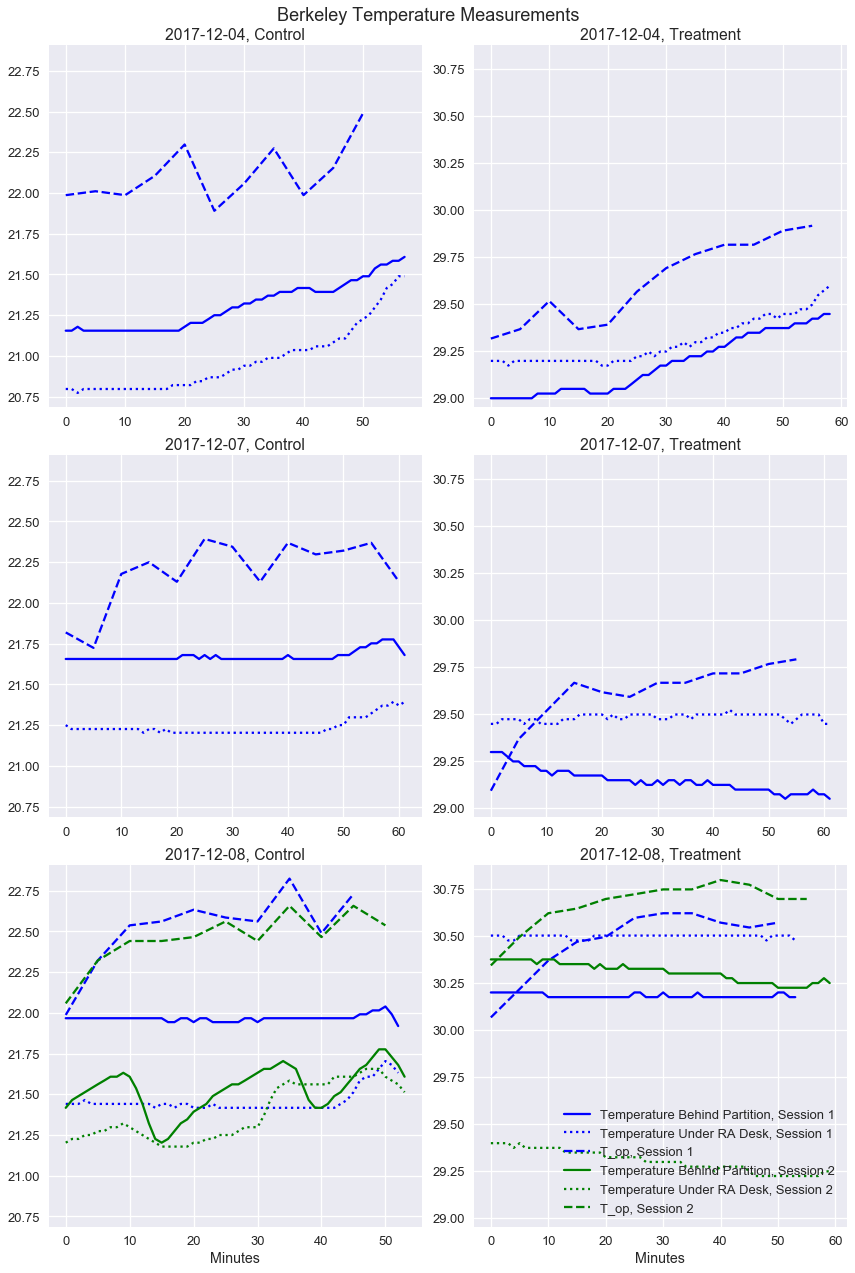

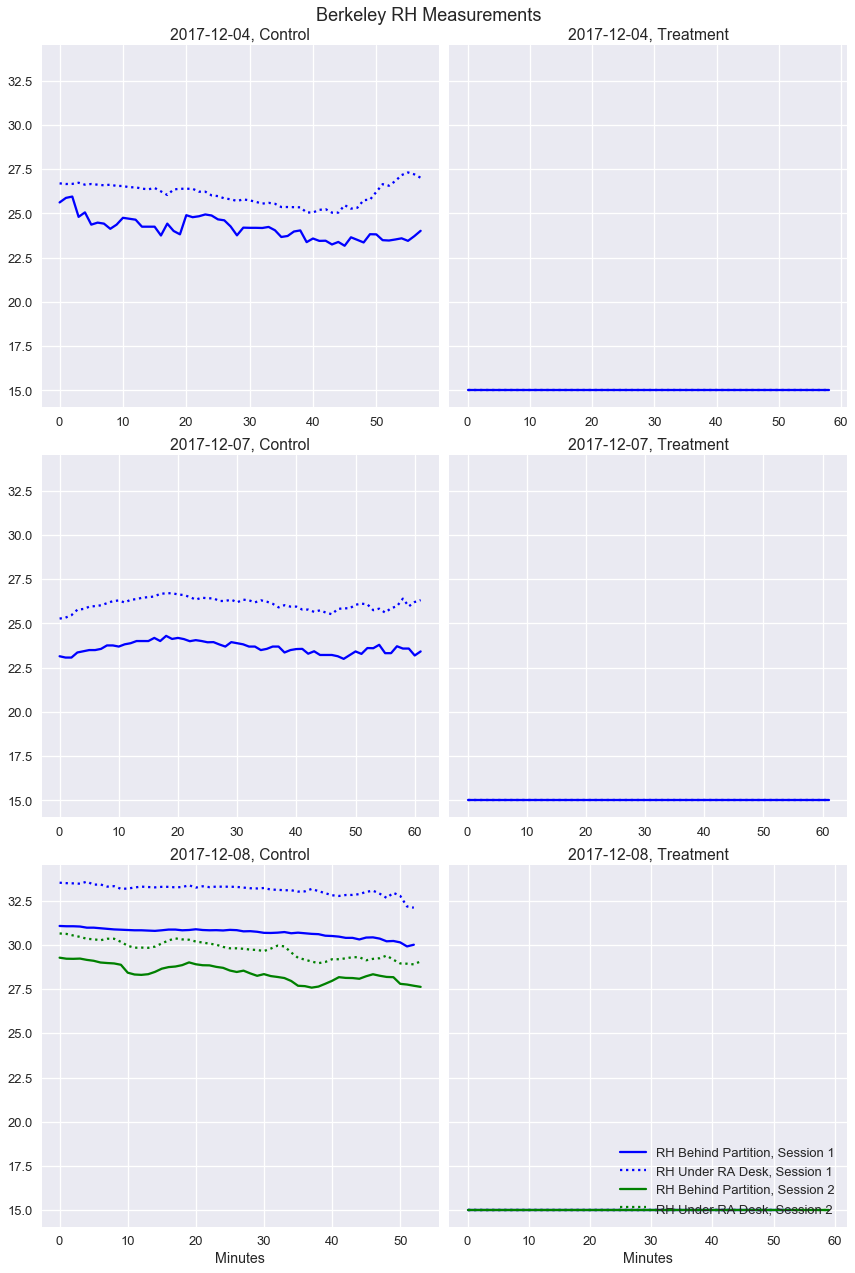

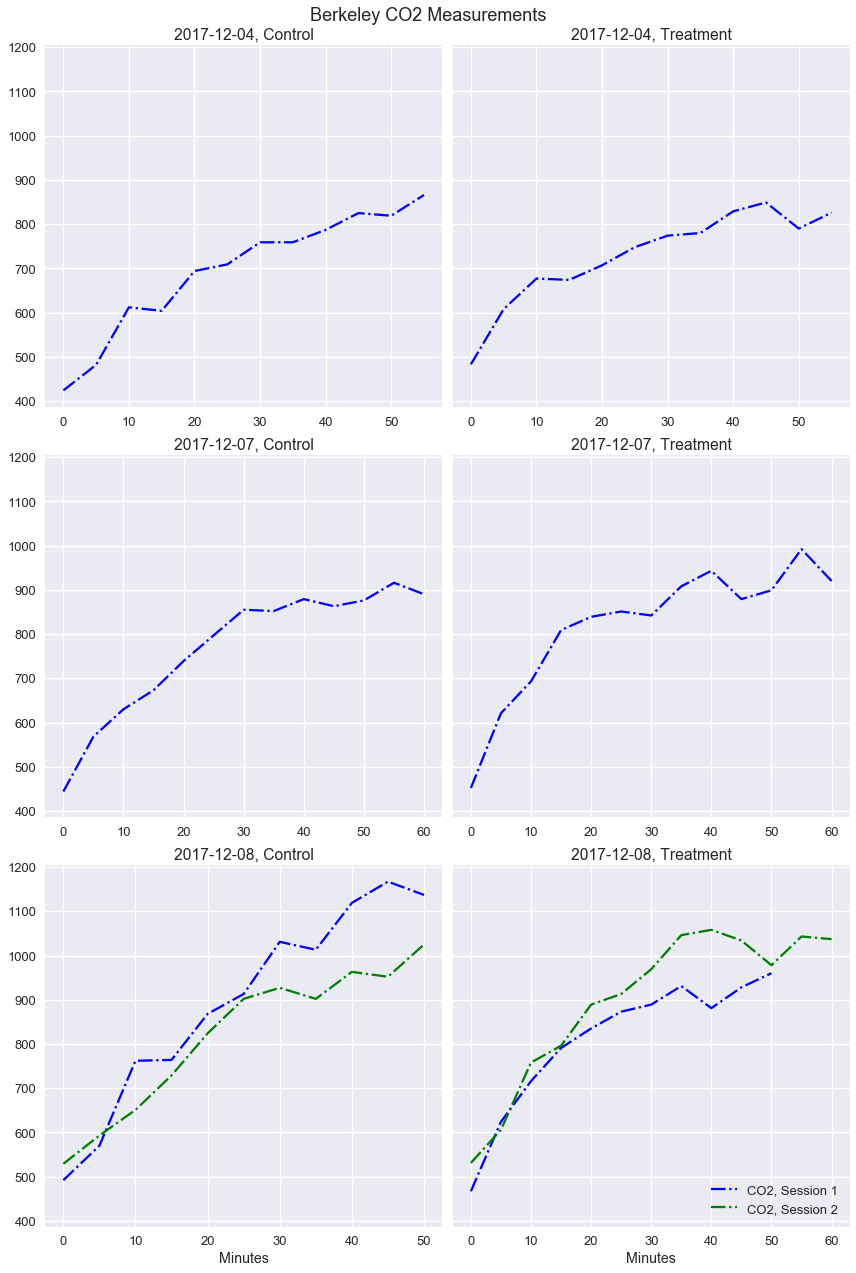

In [183]:
# make full plots
idx = pd.IndexSlice
full_fig_timing = timing_df.loc[idx[full_fig_start_date:end_date,:,:],:]
x = make_full_plots(dfs_berk,full_fig_timing,out_name)

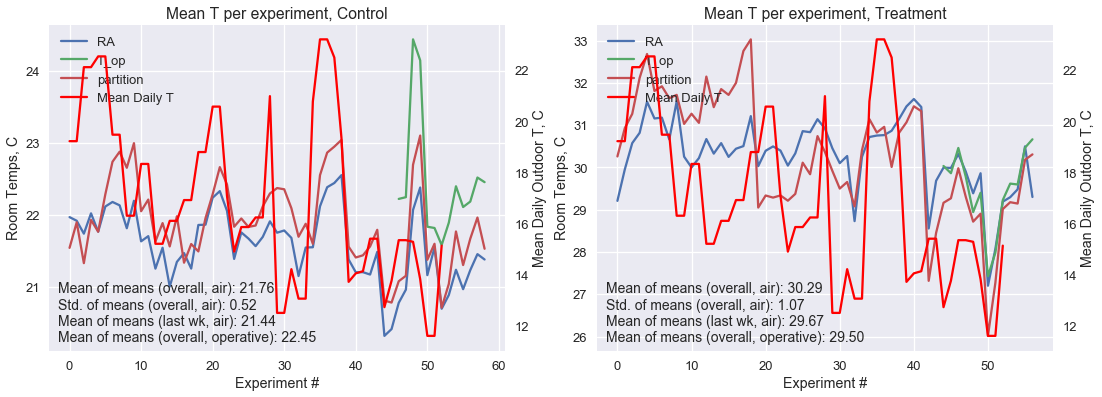

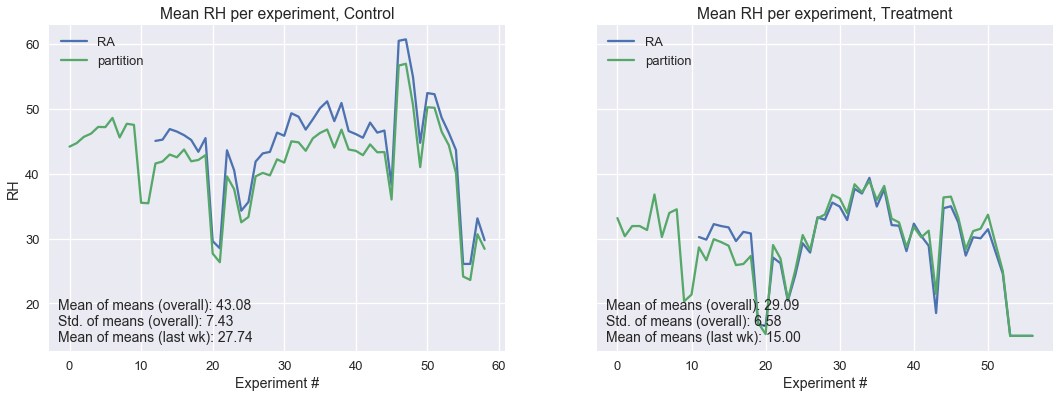

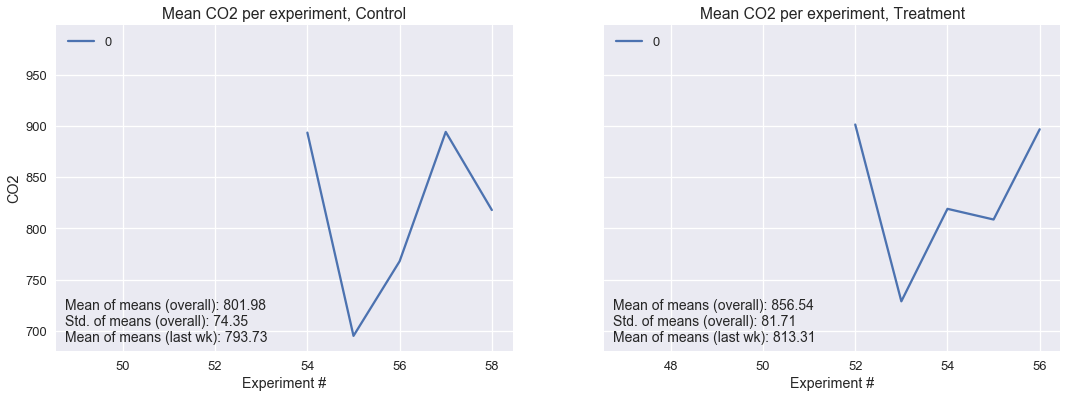

In [133]:
## get means over full experiment
means,od_data,loc_names = get_session_level_data(dfs_berk,timing_df)

# # ## get means over this week
means_this_week,od_data_this_week,loc_names = get_session_level_data(dfs_berk,full_fig_timing)

# # ## Plot
plot_means(means,means_this_week,od_data,loc_names,out_name_means)

# Busara

In [156]:
bus_dir = join(home_dir,'Busara data','Main experiment data')
timing_fpath_bus = join(bus_dir,'experiment_timing.csv')
temps_dir_bus = join(bus_dir,'Temperature')

start_date_bus_str = '20171017'
full_fig_start_date_bus_str = '20171211'
temps_detail_fig_prefix = 'temps_detail'

start_date_bus = dt.strptime(start_date_bus_str,'%Y%m%d')
full_fig_start_date_bus = dt.strptime(full_fig_start_date_bus_str,'%Y%m%d')

experiment_dates = [i[:-5] for i in listdir(join(temps_dir_bus,'indoor')) if i[0] != '.' and i[-4:]=='Warm']
experiment_dates.sort()
experiment_dates = [dt.strptime(i,'%Y%m%d') for i in experiment_dates 
                    if dt.strptime(i,'%Y%m%d') >= start_date_bus]
end_date_bus = experiment_dates[-1]

temps_detail_fig_name = '{}_{}'.format(temps_detail_fig_prefix,end_date_bus.strftime('%Y%m%d'))

In [135]:
def get_timing_df_bus(timing_fpath):
    timing_df = pd.read_csv(timing_fpath_bus,usecols=range(5))
    timing_df.loc[:,['Date','Session in day']] = timing_df.loc[:,['Date','Session in day']].fillna(method='ffill')
    timing_df['Date'] = pd.to_datetime(timing_df['Date'])
    timing_df = timing_df.set_index(['Date','Session in day','Treatment group'])
    return timing_df

## Get timing data

In [136]:
raw_timing_df_bus = get_timing_df_bus(timing_fpath_bus)
timing_df_bus = correct_raw_timing_df(raw_timing_df_bus,start_date_bus,end_date_bus)

## Get Outdoor Temp/RH Data

In [146]:
def get_outdoor_data_bus(temp_dir):
    files_od = glob(join(temp_dir,'Busara*.csv'))
    df_od = pd.DataFrame()

    for f in files_od:
        this_df = pd.read_csv(f,usecols=[0,1,2],index_col=0,parse_dates=True,header=1)
        this_df.columns = ['T','RH']
        this_df.index.name = 'time'
        
        # Get rid of logging flags
        this_df = this_df[this_df.iloc[:,0] != ' ']
        this_df = this_df.astype(float)

        # convert to celsius
        this_df['T'] = (this_df['T'] - 32) * 5/9
        df_od = df_od.append(this_df)

    df_od = df_od[~df_od.index.duplicated(keep='last')].sort_index()
    
    # remove first and last day to ignore days where we did not get full recording
    df_od = df_od.iloc[1:-1,:]
    
    # separate out into daily min,mean,max
    groups = df_od.groupby(df_od.index.date)
    dfs_od = {'all':df_od,
             'min': groups.min(),
             'mean': groups.mean(),
             'max': groups.max()}
    
    for i in ['min','mean','max']:
        # remove first and last day to ignore days where we did not get full recording
        dfs_od[i] = dfs_od[i].iloc[1:-1,:]
    
    
    return dfs_od

In [147]:
dfs_od_bus = get_outdoor_data_bus(join(temps_dir_bus,'outdoor'))

## Get temp/RH data from sessions

In [151]:
def load_vals_bus(download_dates):
    """Input all temperature data from Berkeley experiment into dataframe."""
    
    dfs = {'treatment':{},
          'control':{},
          'outdoor':{}}

    # grab room temp data from both control and treatment rooms
    for gi,gx in enumerate([('Cool','control'),('Warm','treatment')]):
        
        ga = gx[0]
        g = gx[1]
        tx_lab = ga[0].upper()
        
        ## now download data from sensors we switched to
        for dx,d in enumerate(download_dates):
            d_str = d.strftime('%Y%m%d')
            for loc in [('far','F'),('near','N')]:
                try:
                    new_df = pd.read_csv(join(temps_dir_bus,'indoor','{}_{}'.format(d_str,ga),
                        '{}_Temp_{}{}.csv'.format(d_str,tx_lab,loc[1])),usecols=[1,2,3],header=1,
                       index_col=0,parse_dates=True).loc[pd.to_datetime(sensor_swap_date):,:]
                except:
                    new_df = pd.read_csv(join(temps_dir_bus,'indoor','{}_{}'.format(d_str,ga),
                        '{}_Temp_{}{}..csv'.format(d_str,tx_lab,loc[1])),usecols=[1,2,3],header=1,
                       index_col=0,parse_dates=True).loc[pd.to_datetime(sensor_swap_date):,:]
                new_df.columns=['T','RH']
                new_df.index.name='time'
                if dx == 0:
                    dfs[g][loc[0]] = new_df
                else:
                    dfs[g][loc[0]] = dfs[g][loc[0]].append(new_df)
            
        for loc in ['far','near']:  
            # drop duplicate times from multiple files
            dfs[g][loc] = dfs[g][loc][~dfs[g][loc].index.duplicated(keep='last')].sort_index()
            
            # drop data logger flag rows
            dfs[g][loc] = dfs[g][loc][dfs[g][loc].notnull().all(axis=1)]
        
    return dfs

In [154]:
dfs_id_bus = load_vals_bus(experiment_dates)

## Make Plots

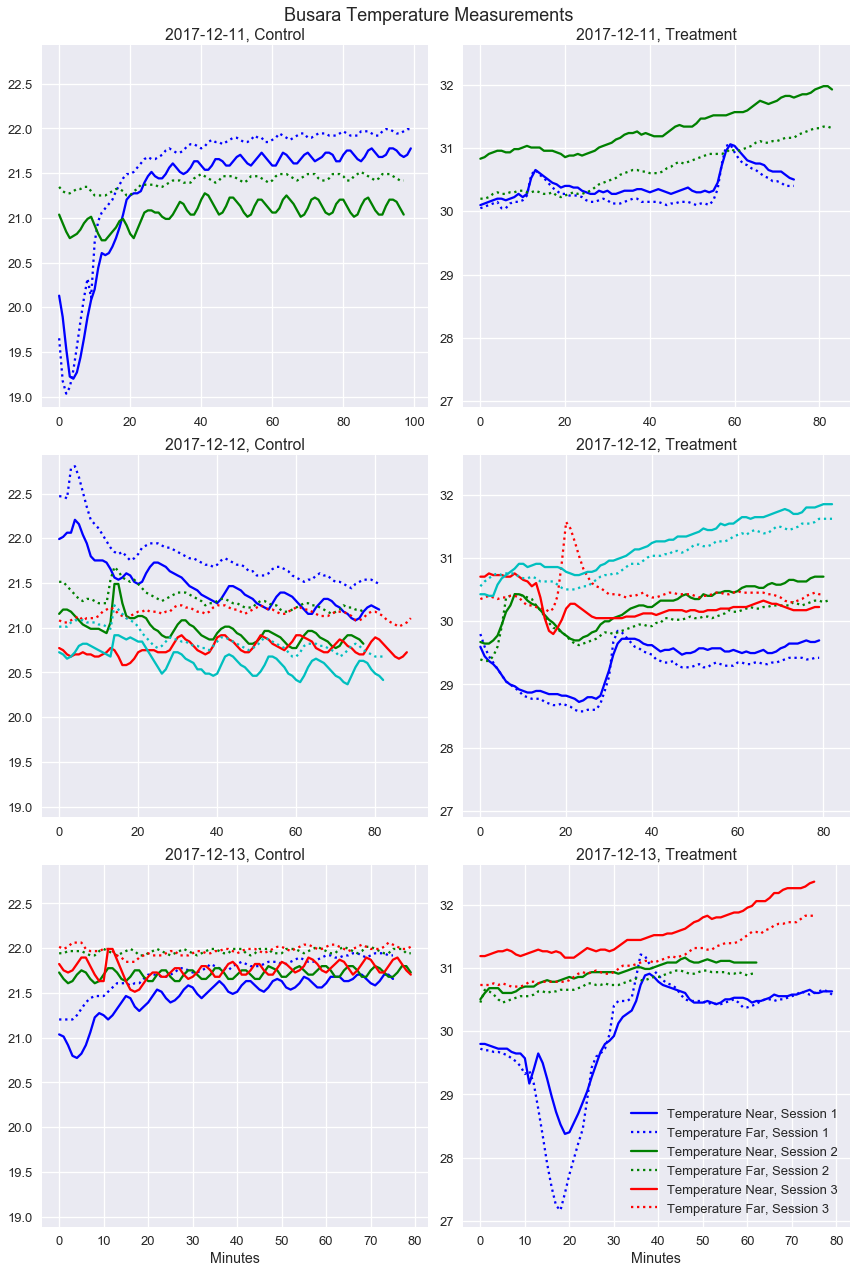

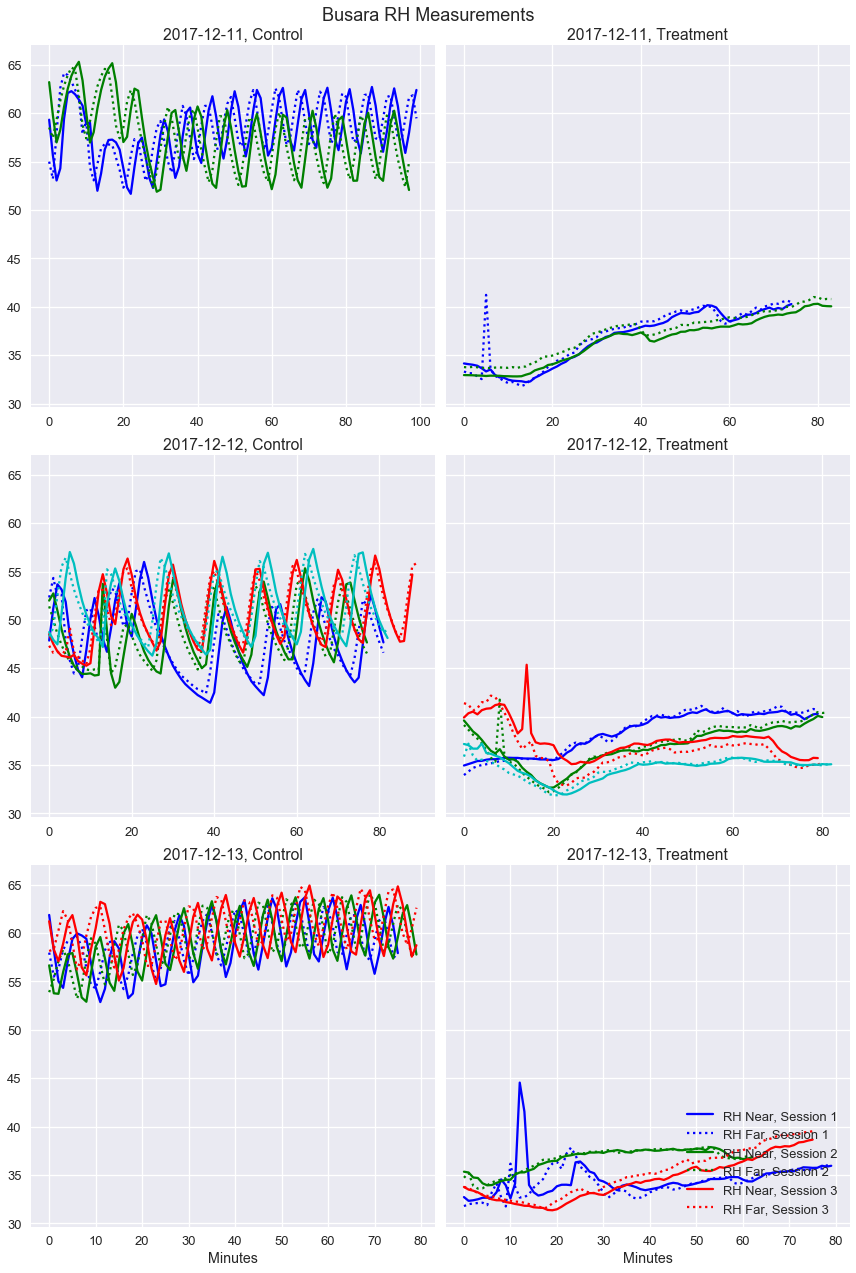

In [182]:
# make full plots
idx = pd.IndexSlice
full_fig_timing_bus = timing_df_bus.loc[idx[full_fig_start_date_bus:end_date_bus,:,:],:]
x = make_full_plots(dfs_id_bus,full_fig_timing_bus,out_name,site_str='Busara',
                   plot_top=False, plot_co2=False)

/Users/ianbolliger/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/ianbolliger/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/ianbolliger/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1202: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/Users/ianbolliger/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/ianbolliger/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/ianbolliger/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.

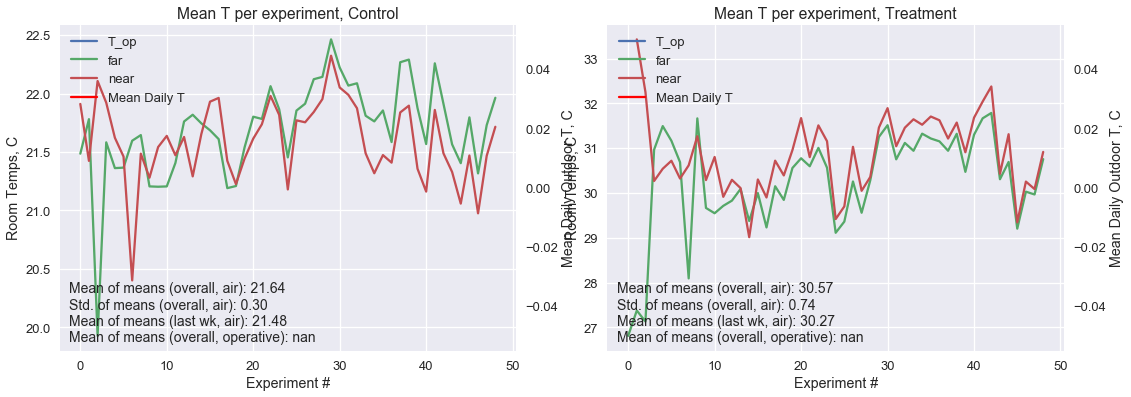

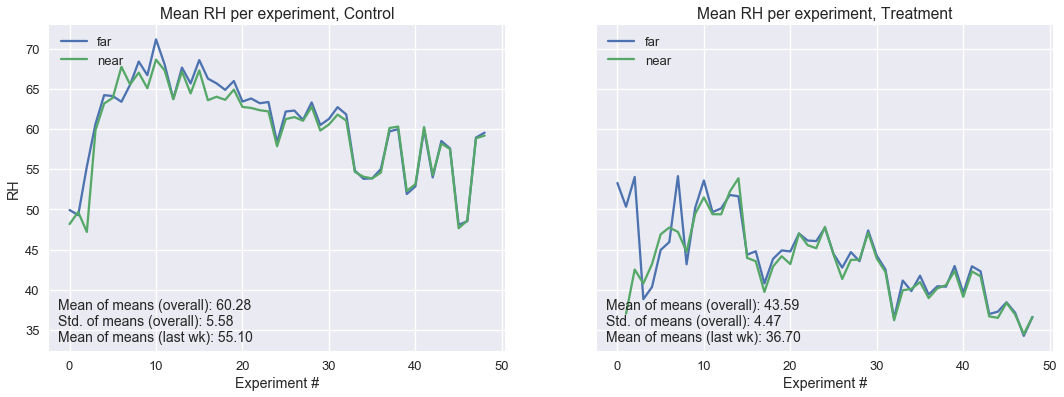

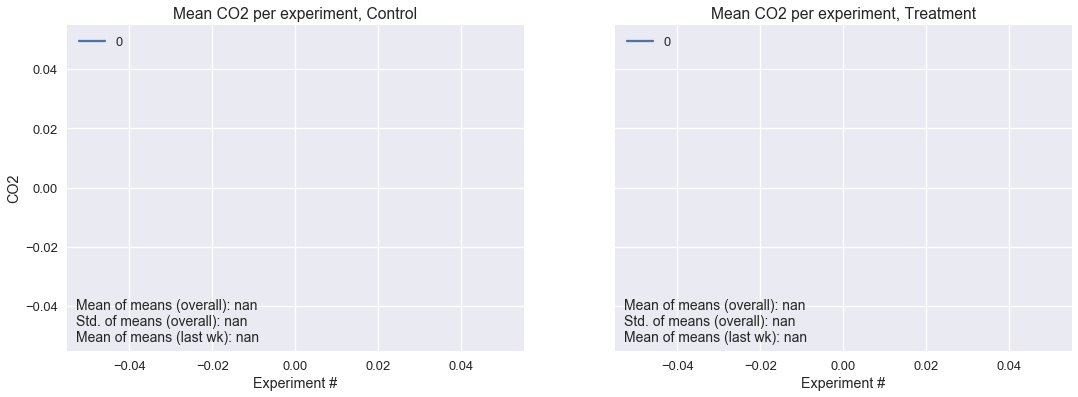

In [180]:
## get means over full experiment
means,od_data,loc_names = get_session_level_data(dfs_id_bus,timing_df_bus)

# # ## get means over this week
means_this_week,od_data_this_week,_ = get_session_level_data(dfs_id_bus,full_fig_timing_bus)

# # ## Plot
plot_means(means,means_this_week,od_data,loc_names,out_name_means,site_str='Busara')